In [12]:
import os
import sys
from pathlib import Path
import math

root = Path(os.getcwd()).parent
sys.path.append(str(root))

import pandas as pd

# Load morphological data
morph_df = pd.read_csv("../data/morphology_data_cleaned.csv")
morph_df.rename(columns={"id": "neighborhood_id"}, inplace=True)

# Load health data
health_df_soc = pd.read_excel("../data/synthetic_health_data.xlsx", sheet_name="Participant_SocioDemograph_Data")
health_df_clin = pd.read_excel("../data/synthetic_health_data.xlsx", sheet_name="Participant_HEALTH_Data")

# Merge health data
health_df = pd.merge(health_df_soc, health_df_clin, on=["participant_id", "neighborhood_id"], how="inner")

# Merge morphology and health data
df = pd.merge(morph_df, health_df, on="neighborhood_id", how="inner")

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (2671, 35)


In [13]:
numerical_cols = [
    "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "GHQ12_score",
    "z_distance", "lst_mean", "solar_summ", "solar_wint",
    "pm10_mean", "pm25_mean", "no2_mean", "noiseday_m", "noisenight",
    "age", "points_sleep_deprivation", "sleeping_hours"
]

categorical_cols = [
    "typology", "sex", "income", "education_level",
    "heart_failure", "heart_rhythm", "d_metabolic_diabetes_I",
    "d_metabolic_diabetes_II", "d_metabolic_obesity",
    "d_breath_respiratory", "d_breath_asthma", "sleep_disorder_hot"
]

In [14]:
from sklearn.model_selection import train_test_split

# Define features and target
features = df.drop(columns=["participant_id", "neighborhood_id", "bedtime_hour"])

# Drop columns that are neither numerical nor categorical
features = features.drop(columns=[col for col in features.columns if col not in numerical_cols + categorical_cols])

# Drop rows with missing values
features = features.dropna().reset_index(drop=True)

# Encode categorical variables
for col in categorical_cols:
    dummies = pd.get_dummies(features[col], prefix=col)
    features = pd.concat([features.drop(columns=[col]), dummies], axis=1)

# Standardize numerical features
features[numerical_cols] = pd.to_numeric(features[numerical_cols].stack(), errors='coerce').unstack()
for col in numerical_cols:
    features[col] = (features[col] - features[col].mean()) / features[col].std()

In [15]:
import numpy as np

def interpret_gmm_selection(n_range, aics, bics, threshold: float = 0.05):
    n_range = np.array(n_range)
    aics = np.array(aics)
    bics = np.array(bics)
    
    # 1. Identify the Minima
    best_aic_k = n_range[np.argmin(aics)]
    best_bic_k = n_range[np.argmin(bics)]

    # 2. Check for Edge Cases (Did we test enough?)
    if best_bic_k == n_range.max():
        print("The optimal BIC is at the very edge of the range.")
        print("   Action: the maximum number of components should be increased and run again.")
    elif best_bic_k == n_range.min():
        print("The optimal BIC is the lowest number tested.")
        print("   Action: test fewer components (e.g., 1 or 2).")

    # If AIC is much higher than BIC, the model is likely overfitting complex noise
    diff = best_aic_k - best_bic_k
    if diff > 5:
        print(f"High Disagreement: AIC suggests {diff} more clusters than BIC.")
        print(f"   Action: Stick closer to k={best_bic_k} to avoid overfitting.")
    
    # If we analyze the delta BIC across the range, we can find logical choices
    bic_min = bics.min()
    bic_range_val = bics.max() - bic_min
    
    # Check candidates where BIC is 'close enough' (within 5% of the range from the bottom)
    pragmatic_candidates = []
    
    for k, score in zip(n_range, bics):
        norm_score = (score - bic_min) / bic_range_val
        if norm_score < threshold and k < best_bic_k:
            pragmatic_candidates.append(k)
            
    if pragmatic_candidates:
        print(f"   Pragmatic Choice: Consider k={pragmatic_candidates[0]}")
        print(f"   Motivation: k={pragmatic_candidates[0]} is nearly as good as the optimal k={best_bic_k} but uses fewer clusters.")
    else:
        print(f"   The optimal k={best_bic_k} is a solid choice.")

    return best_aic_k, best_bic_k


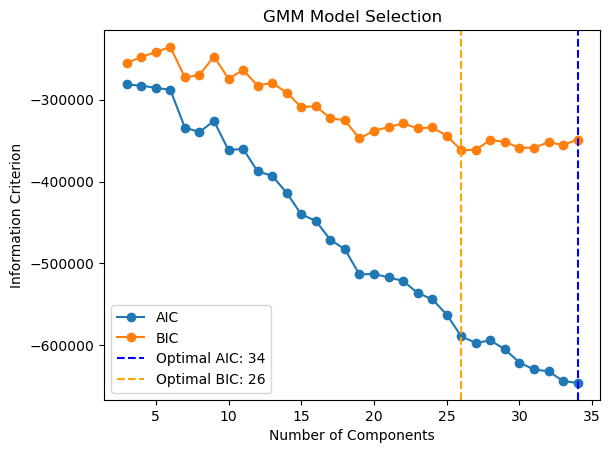

High Disagreement: AIC suggests 8 more clusters than BIC.
   Action: Stick closer to k=26 to avoid overfitting.
   The optimal k=26 is a solid choice.


In [16]:
# import and fit GMM in a range of components
from sklearn.mixture import GaussianMixture

aic_values = []
bic_values = []
n_components_range = range(3, 35)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(features)
    aic_values.append(gmm.aic(features))
    bic_values.append(gmm.bic(features))
# Find optimal number of components
optimal_n_components_aic = n_components_range[aic_values.index(min(aic_values))]
optimal_n_components_bic = n_components_range[bic_values.index(min(bic_values))]

# Plot AIC and BIC values
import matplotlib.pyplot as plt
plt.plot(n_components_range, aic_values, label='AIC', marker='o')
plt.plot(n_components_range, bic_values, label='BIC', marker='o')
# Mark optimal points
plt.axvline(optimal_n_components_aic, color='blue', linestyle='--', label=f'Optimal AIC: {optimal_n_components_aic}')
plt.axvline(optimal_n_components_bic, color='orange', linestyle='--', label=f'Optimal BIC: {optimal_n_components_bic}')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.title('GMM Model Selection')
plt.legend()
plt.show()

interpret_gmm_selection(n_components_range, aic_values, bic_values);

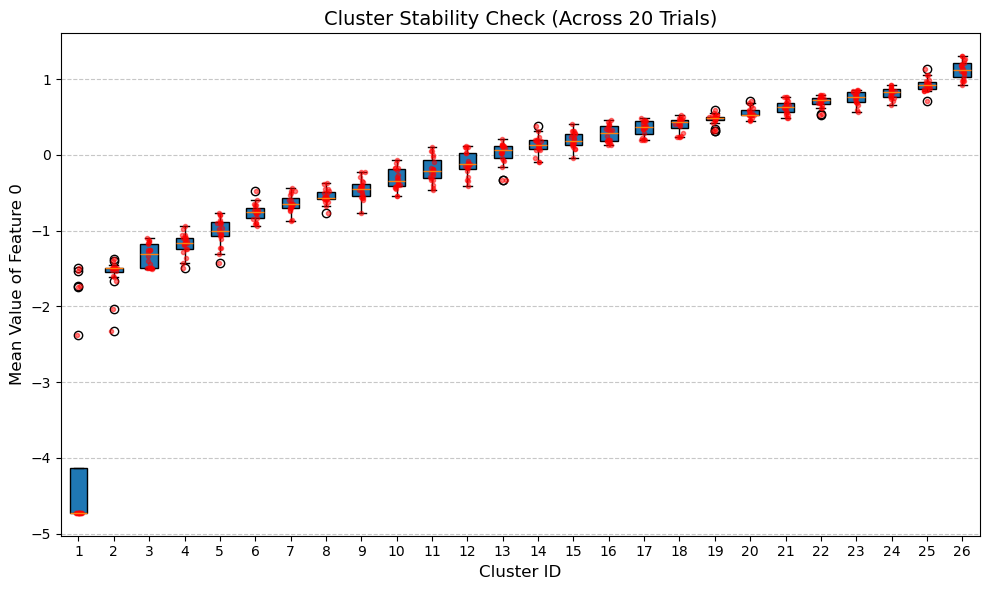

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# This code is to check the stability of GMM clustering results across multiple trials

# Configuration
n_trials = 20
n_components = optimal_n_components_bic
aligned_means = []
aligned_weights = []

for i in range(n_trials):
    # Fit with random seed
    gmm = GaussianMixture(n_components=n_components, random_state=np.random.randint(0, 10000))
    gmm.fit(features)
    order = np.argsort(gmm.means_[:, 0])
    aligned_means.append(gmm.means_[order])
    aligned_weights.append(gmm.weights_[order])

# Shape: (n_trials, n_components, n_features)
means_array = np.array(aligned_means) 
weights_array = np.array(aligned_weights)

plt.figure(figsize=(10, 6))
data_to_plot = [means_array[:, i, 0] for i in range(n_components)]
plt.boxplot(data_to_plot, patch_artist=True)
plt.title(f'Cluster Stability Check (Across {n_trials} Trials)', fontsize=14)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Mean Value of Feature 0', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(n_components):
    y = means_array[:, i, 0]
    x = np.random.normal(1 + i, 0.04, size=len(y)) # Add small random noise to x for visibility
    plt.plot(x, y, 'r.', alpha=0.5)

plt.tight_layout()
plt.show()

In [18]:
gmm = GaussianMixture(n_components=optimal_n_components_bic, random_state=42)
gmm.fit(features)

,n_components,26
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42
